# Efficient Frontier

The efficient frontier is the Pareto-optimal curve representing the best attainable trade-off between expected return and risk. Every point on this frontier dominates all other feasible portfolios by offering a higher return for the same risk (or lower risk for the same return), making it the gold standard for comparing asset allocation strategies.

Constructing this frontier requires solving hundreds of portfolio optimization problems, typically by sweeping across different risk-aversion parameters or target return levels. This computational intensity makes solver performance pivotal, as each speedup compounds. Leveraging a GPU solver like cuOpt dramatically accelerates this iterative workflow, significantly cutting runtime compared to CPU-only approaches.

In this notebook, we generate the efficient frontier by iterating over different risk aversion levels. We can compare the overall performance using cuOpt GPU solver vs. a CPU solver and see how the speed-up on a single optimization problem multiplies in one of the advanced, practical workflows. 

In [2]:
import os
from cufolio import cvar_utils
from cufolio.cvar_parameters import CvarParameters
import cvxpy as cp

In [6]:
# Define CVaR optimization parameters for Efficient Frontier (EF) construction
ef_cvar_params = CvarParameters(
    w_min=0.0, w_max=1.0,             # Asset weight bounds (no shorting)
    c_min=0.0, c_max=0.0,             # Cash holdings bounds (no cash allocation)
    L_tar=1.0,                    # Leverage target (fully invested, sum of weights = 1 for long only)
    T_tar=None,                   # No turnover constraint
    cvar_limit=None,              # Max CVaR (unconstrained)
    risk_aversion=1,              # Base risk aversion (will be varied to generate EF)
    confidence=0.95,              # CVaR confidence level
    num_scen=20000,               # Number of return scenarios
    fit_type="kde"           # Return distribution estimation method
)

In [7]:
# --- User inputs for Efficient Frontier (EF) Example ---
ef_dataset_name = "sp500"
ef_return_type = "LOG"
ef_data_preprocessing_device = "GPU"

# Get date range and file path
ef_regime = "recent"
ef_range = ('2022-01-01', '2024-07-01')
ef_regime_dict = {"name": ef_regime, "range": ef_range}
ef_dataset_path = f"../../data/stock_data/{ef_dataset_name}.csv"

# Compute returns for EF
ef_returns_dict = cvar_utils.calculate_returns(
    ef_dataset_path,
    ef_regime_dict,
    ef_return_type,
    ef_cvar_params,
    device=ef_data_preprocessing_device
)

In [8]:
# --- Efficient Frontier (EF) Settings ---
# Optional: Define custom portfolios to display on the EF plot
ef_custom_portfolios_dict = {
    "NVDA-AMZN portfolio": ({"NVDA": 0.72, "AMZN": 0.18}, 0.1), # ({asset_weights_dict}, cash_holding_float)
    "AAPL-MSFT portfolio": ({"AAPL": 0.29, "NKE": 0.01, "MSFT": 0.6}, 0.1),
}

ef_plot_title = f"Efficient Frontier Plot – {ef_dataset_name} ({ef_regime})"
ef_output_folder = "/tmp/EF_results/" # Folder to save EF results
ef_results_csv_path = os.path.join(ef_output_folder, "EF_results.csv")
ef_plot_png_path = os.path.join(ef_output_folder, "EF_plot.png")

# Range for risk aversion parameter (lambda_risk)
ef_min_risk_aversion_exp = -3         # Corresponds to 1e-3 (high risk appetite)
ef_max_risk_aversion_exp = 1          # Corresponds to 1e1 = 10 (risk-averse)
ef_risk_aversion_steps = 50           # Number of risk aversion levels for a smoother EF


# Prepare output directory
os.makedirs(ef_output_folder, exist_ok=True)

Computing efficient frontier with 50 portfolios...
Setting parameter log_to_console to false
Setting parameter method to 1
Setting parameter log_to_console to false
Setting parameter method to 1
Setting parameter log_to_console to false
Setting parameter method to 1
Setting parameter log_to_console to false
Setting parameter method to 1
Setting parameter log_to_console to false
Setting parameter method to 1
   ✓ Completed 5/50 portfolios
Setting parameter log_to_console to false
Setting parameter method to 1
Setting parameter log_to_console to false
Setting parameter method to 1
Setting parameter log_to_console to false
Setting parameter method to 1
Setting parameter log_to_console to false
Setting parameter method to 1
Setting parameter log_to_console to false
Setting parameter method to 1
   ✓ Completed 10/50 portfolios
Setting parameter log_to_console to false
Setting parameter method to 1
Setting parameter log_to_console to false
Setting parameter method to 1
Setting parameter log_

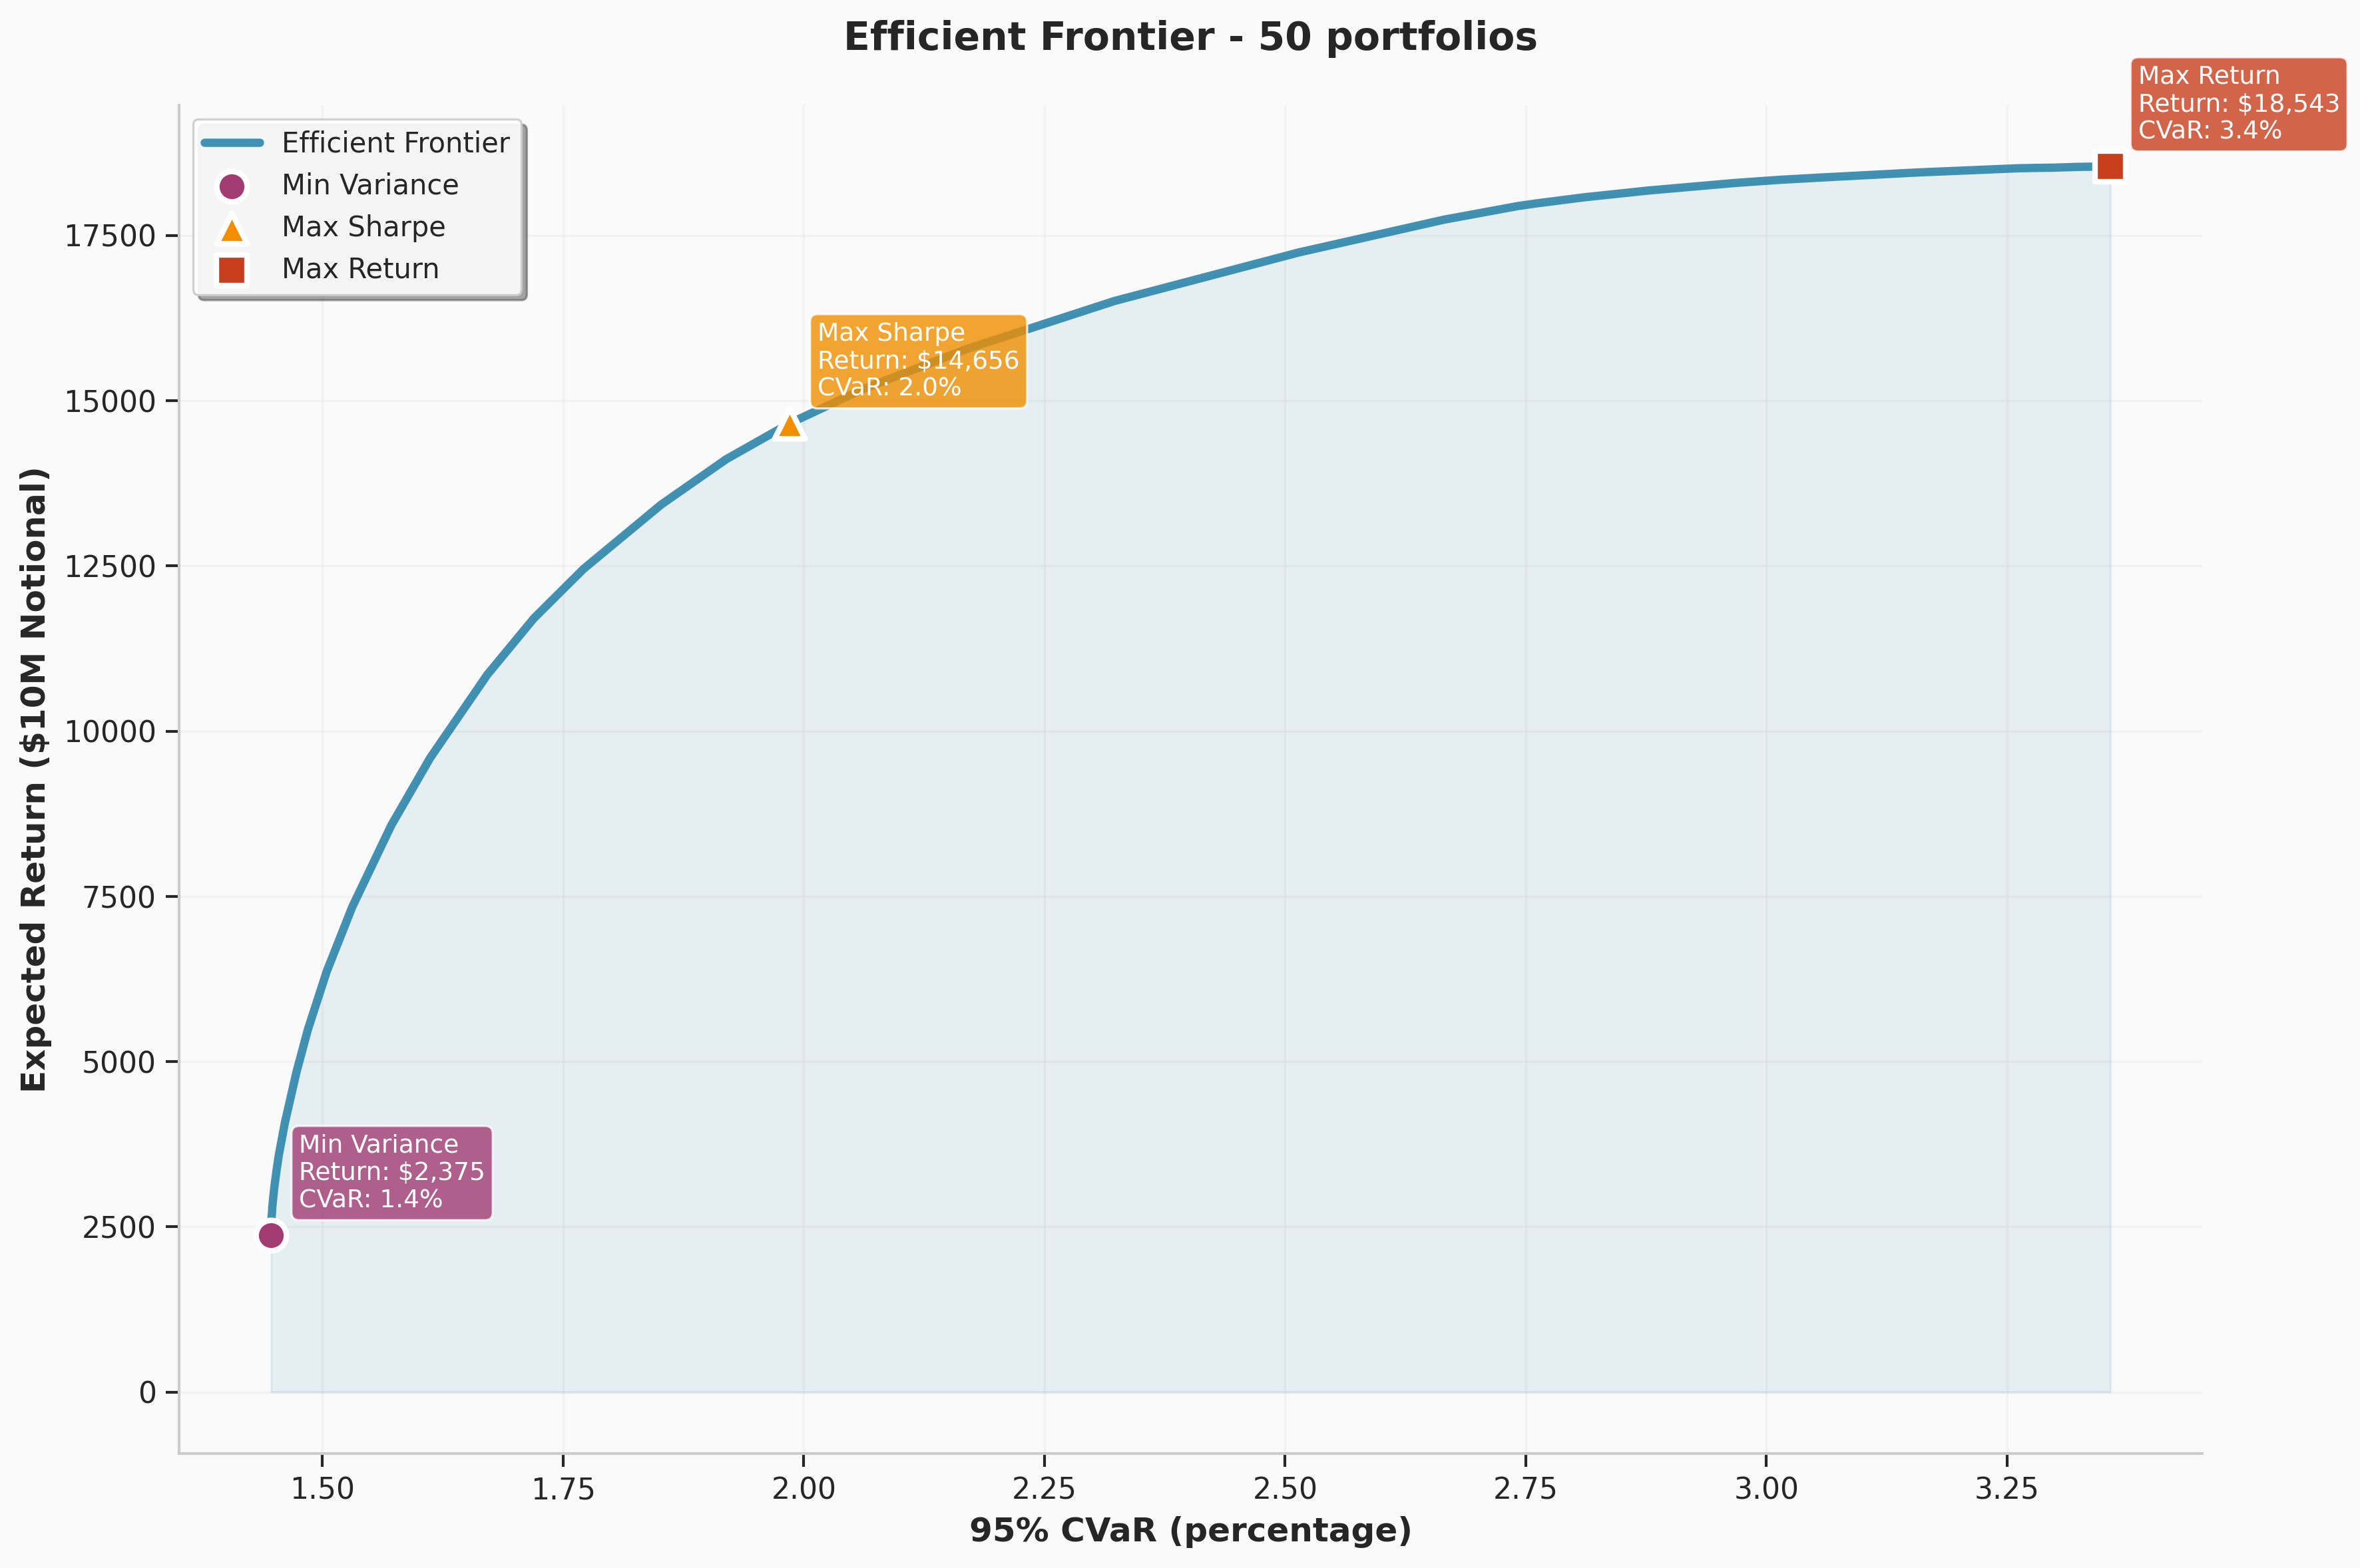

Efficient frontier analysis complete!


In [9]:
# Simple usage
from cufolio.cvar_utils import create_beautiful_efficient_frontier

ef_solver_settings = {"solver": cp.CUOPT, "verbose": False, 'solver_method': 'PDLP'}
results_df, fig, ax = create_beautiful_efficient_frontier(
    ef_dataset_path,
    ef_regime_dict,
    "LOG",
    ef_cvar_params,
    ef_solver_settings,
    style="publication", #"publication", "presentation", "minimal"
    color_scheme="modern", #"modern", "classic", "vibrant"
    ra_num = ef_risk_aversion_steps,
    min_risk_aversion= ef_min_risk_aversion_exp,
    max_risk_aversion = ef_max_risk_aversion_exp,
    save_path="efficient_frontier.png",
    show_discretized_portfolios=False,
    discretization_params={
        "weight_discretization": 50,
        "min_weight": ef_cvar_params.w_min,
        "max_weight": ef_cvar_params.w_max
    },
    print_portfolio_results= False
)

In [10]:
results_df

,regime,solver,solve time,return,CVaR,obj,risk_aversion,variance,volatility,sharpe
0,recent,CUOPT,0.826858,0.000237,0.014468,0.144444,10.000000,0.000053,0.007303,0.516124
1,recent,CUOPT,0.343375,0.000240,0.014468,0.119649,8.286428,0.000053,0.007306,0.520722
2,recent,CUOPT,0.332107,0.000243,0.014468,0.099104,6.866488,0.000053,0.007307,0.527078
3,recent,CUOPT,0.323090,0.000247,0.014469,0.082080,5.689866,0.000053,0.007308,0.535596
4,recent,CUOPT,0.333064,0.000251,0.014470,0.067974,4.714866,0.000053,0.007309,0.544495
5,recent,CUOPT,0.312684,0.000255,0.014471,0.056282,3.906940,0.000053,0.007310,0.553905
6,recent,CUOPT,0.331447,0.000262,0.014472,0.046589,3.237458,0.000053,0.007309,0.568288
7,recent,CUOPT,0.340642,0.000268,0.014473,0.038560,2.682696,0.000053,0.007310,0.581012
8,recent,CUOPT,0.331241,0.000272,0.014477,0.031910,2.222996,0.000053,0.007313,0.590294
9,recent,CUOPT,0.341435,0.000280,0.014480,0.026392,1.842070,0.000054,0.007315,0.607690
